In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from functools import partial

from prepare_plasticc import config
from tokenizer import LCTokenizer
from viz import plot_lightcurve
from gaussian_process import fit_2d_gp
import time

from models.patchgpt import PatchGPT, PatchGPTConfig
import torch

/opt/anaconda3/envs/gpt-ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('plasticc/plasticc_train_lightcurves.csv.gz')
#df = pd.read_csv('plasticc/plasticc_test_lightcurves_02.csv.gz')

In [3]:
object_ids = np.unique(df['object_id'].values)

In [4]:
tokenizer = LCTokenizer(-10000, 10000, 500, 1000, 500, bands=config["bands"],
                            transform=np.arcsinh, inverse_transform=np.sinh,
                            min_sn=3, window_size=5)

In [5]:
start_time = time.time()
#tokenizer.encode(df)
print(time.time() - start_time)

2.193450927734375e-05


0.2262420654296875


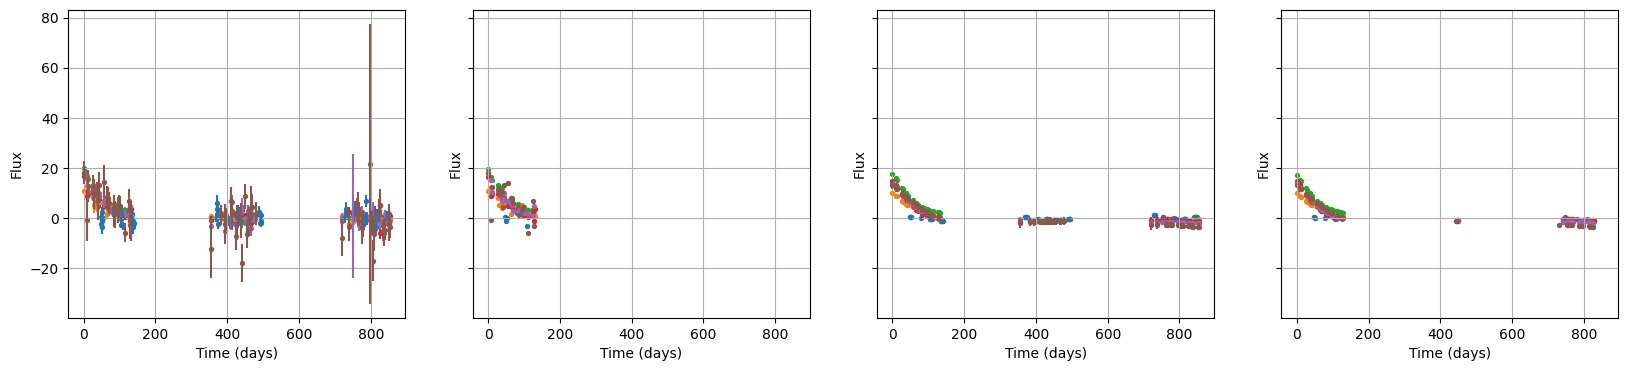

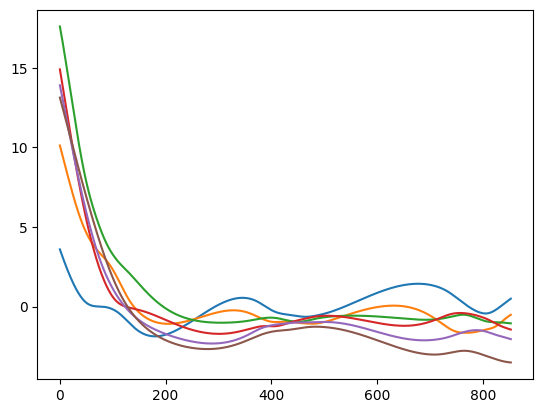

In [42]:
for object_id in object_ids[10:11]:
    df_object = df.loc[df['object_id'] == object_id]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    start_time = time.time()
    resampled_df, (sampled_times, sampled_obs, _, sampled_mask), _ = fit_2d_gp(df_object, config['pb_wavelengths'], sample_interval=1)
    print(time.time() - start_time)
    plot_lightcurve([df_object, tokenizer.decode(tokenizer.encode(df_object)), resampled_df, tokenizer.decode(tokenizer.encode(resampled_df))])
    plt.plot(sampled_times, sampled_obs[0,:])
    plt.plot(sampled_times, sampled_obs[1,:])
    plt.plot(sampled_times, sampled_obs[2,:])
    plt.plot(sampled_times, sampled_obs[3,:])
    plt.plot(sampled_times, sampled_obs[4,:])
    plt.plot(sampled_times, sampled_obs[5,:])

In [43]:
patch_size = 7

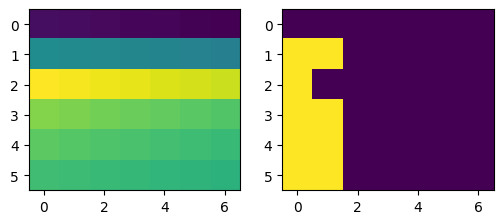

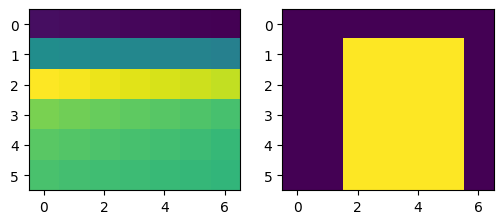

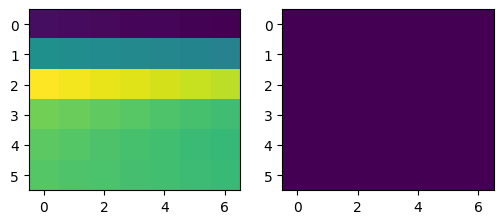

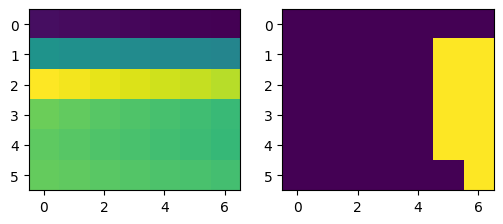

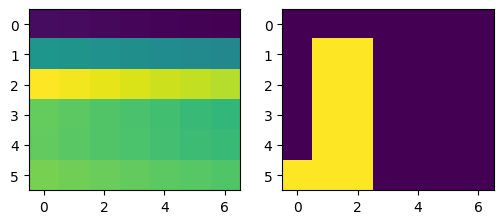

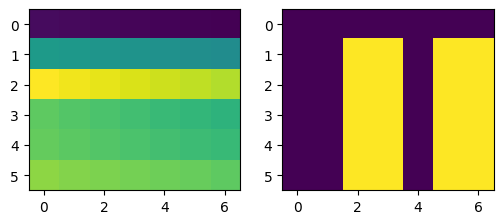

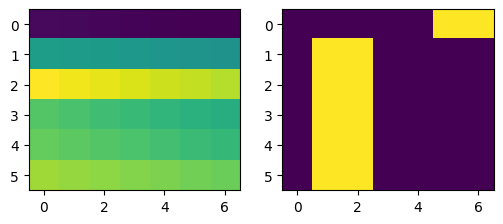

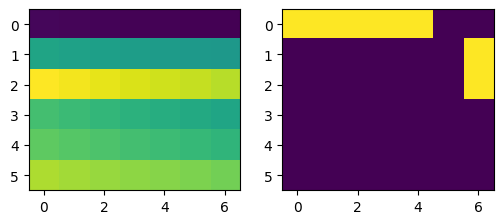

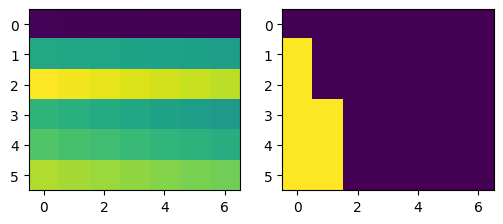

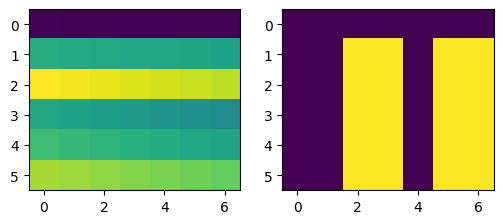

In [44]:
for i in range(10):
    fig, axes = plt.subplots(1,2, figsize=(6,3))
    axes[0].imshow(sampled_obs[:,i*patch_size:(i+1)*patch_size])
    axes[1].imshow(sampled_mask[:,i*patch_size:(i+1)*patch_size])
    plt.show()

In [45]:
patch_config = PatchGPTConfig(n_channels=6, patch_size=patch_size, random_mask_ratio=0.5, head_type='pretrain_lm')

In [46]:
patch_config

PatchGPTConfig {
  "dropout": 0.0,
  "head_type": "pretrain_lm",
  "model_type": "patchgpt",
  "n_channels": 6,
  "n_embd": 36,
  "n_head": 6,
  "n_labels": 0,
  "n_layer": 6,
  "n_positions": 1024,
  "n_static": 0,
  "patch_size": 7,
  "position_embedding": "absolute",
  "random_mask_ratio": 0.5,
  "transformers_version": "4.39.2"
}

In [47]:
patchify = PatchGPT(patch_config)

In [48]:
patchify

PatchGPT(
  (patchify): Patchify(
    (to_patches): Rearrange('b c (n p) -> b n (p c)', p=7)
  )
  (patch_embedding): Sequential(
    (0): LayerNorm((42,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=42, out_features=36, bias=True)
    (2): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
  )
  (position_embedding_table): Embedding(1024, 36)
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=36, out_features=6, bias=False)
            (query): Linear(in_features=36, out_features=6, bias=False)
            (value): Linear(in_features=36, out_features=6, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
            (distance_embedding): Embedding(2047, 6)
          )
        )
        (proj): Linear(in_features=36, out_features=36, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedFoward(
      

In [49]:
x = torch.tensor(np.expand_dims(np.arcsinh(sampled_obs), 0), dtype=torch.float32).transpose(1, 2)
mask = torch.tensor(np.expand_dims(sampled_mask, 0), dtype=torch.int32).transpose(1, 2)

In [50]:
x.shape

torch.Size([1, 854, 6])

In [51]:
output = patchify(x, attention_mask=mask)

In [52]:
output.loss

tensor(1.6905, grad_fn=<MeanBackward0>)

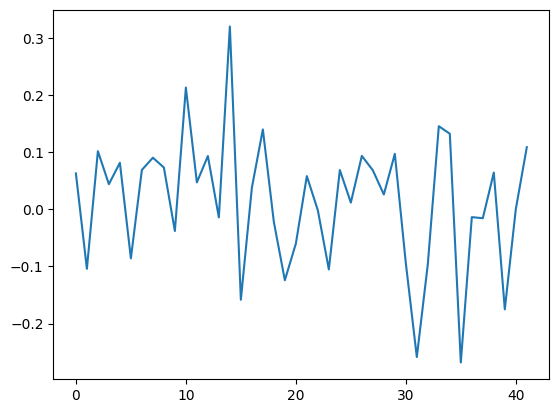

In [53]:
plt.plot(output.patch_pred[0,1,:].detach().numpy())

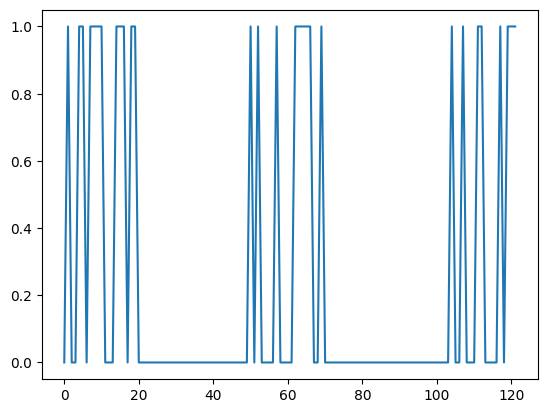

In [54]:
plt.plot(output.patch_mask[0,:].detach().numpy())

In [19]:
dd = np.load('plasticc/train_gp_samples.npy', allow_pickle=True)